In [1]:
import myServices as ms
import models as md
import os
import gc
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve, auc, roc_auc_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity as csim 

import joblib
import random
# import umap
import torch as T
from scipy.interpolate import UnivariateSpline
import holoviews as hv
import panel as pn
import bokeh
from bokeh.resources import INLINE



In [ ]:
# to compute ececution time do: 
# with timeit():
#     # your code, e.g., 
class timeit(): 
    from datetime import datetime
    def __enter__(self):
        self.tic = self.datetime.now()
    def __exit__(self, *args, **kwargs):
        print('runtime: {}'.format(self.datetime.now() - self.tic))

In [ ]:
sklearn.metrics.get_scorer_names()

## Reading hydro logs


In [ ]:

def isKeyInLog(log, key:str=''):
    with open(log, 'r') as f:
        for l in f:
            spl = l.split('-')
            for text in spl:
                if (text == key or text == ' '+key+' '):
                    f.close()
                    return True
    f.close()
    return False

def getKeyContentFromLog(log, key:str=''):
    keyInLog = isKeyInLog(log,key)
    if keyInLog:
        with open(log, 'r') as f:
            lines = f.readlines()
            lines = [line.strip() for line in lines]
            for l in lines:
                spl = l.split(' - ')
                for i in range(len(spl)):
                    if (spl[i] == key or spl[i]  == ' '+key+' '):
                        f.close()
                        return spl[i+1]
    
    else:
        return ''

def scrapeLog(log,keyList:list):
    outDict = {}
    for key in keyList:
        outDict[key] = getKeyContentFromLog(log,key)
    return outDict    

def add_row_to_excel(dictionary, filename):
    '''
    This function use df.to_excel() to add a line to an existing Excel file. If the Excel file is missing, or damaged, the function will create a new one in the place. 
    '''
    # Open the Excel file
    try:
        df = pd.read_excel(filename)
    except FileNotFoundError:
        # If the file does not exist, create an empty DataFrame
        df = pd.DataFrame()

    # Convert the dictionary to a DataFrame
    new_row = pd.DataFrame([dictionary])

    # Append the new row to the DataFrame
    df = pd.concat([df, new_row], ignore_index=True)

    # Write the DataFrame back to the Excel file
    df.to_excel(filename, index=False)


## Importing and manipulating datasets

In [ ]:
keyList = ['model','model name','Epochs','Batch Size','metric','Test metric','Data Set']
folderToScrape= r'C:\Users\abfernan\CrossCanFloodMapping\FloodProbabRNCanAbd\multirun'

subStr = 'executeModels.log'
excellPath = os.path.join(folderToScrape,'logSummaryMultirun.xlsx') 
listOfLosgs = ms.listALLFilesInDirByExt_fullPath(folderToScrape,'.log')

for log in listOfLosgs:
    ditToWrite = scrapeLog(log,keyList)
    add_row_to_excel(ditToWrite,excellPath)



### Data Analyse

In [22]:
class1_Tr = r'C:\Users\abfernan\CrossCanFloodMapping\FloodMappingProjData\HRDTMByAOI\A_DatasetsForMLP\RegionalModelingExplorationDatasets\IndividualsClass1ForRegModelingExpl\TrainingDatasets\TrainingDatasetCombined\Al_Lethbridge_Vs_2_5_13_19_30_31\AL_Lethbridge_RMAOI_normalWRT_Top5Tr.csv'
# class1_Val = r'C:\Users\abfernan\CrossCanFloodMapping\FloodMappingProjData\HRDTMByAOI\A_DatasetsForMLP\RegionalModelingExplorationDatasets\IndividualsClass1ForRegModelingExpl\TrainingDatasets\TrainingDatasetCombined\validationSet_19_23_Normal.csv'


class1_tr_DS =  pd.read_csv(class1_Tr,index_col=None)
# print(class1_tr_DS.describe())

# class1_Val_DS =  pd.read_csv(class1_Val,index_col=None)
# print(class1_Val_DS.describe())

# reader = pd.concat([class1_tr_DS,class1_Val_DS]) # reader = class1_tr_DS # 
reader = class1_tr_DS
descriptor = reader.describe()

print(descriptor)

# dfDescriptorXclx = r'C:\Users\abfernan\CrossCanFloodMapping\FloodProbabRNCanAbd\outputs\Descriptor_class5_Full_Normalized.xlsx'

# descriptor.to_excel(dfDescriptorXclx, index=True)


            x_coord        y_coord         GMorph        RelElev  \
count  2.878480e+05  287848.000000  287848.000000  287848.000000   
mean  -1.269122e+06  254549.037992       0.609553       0.535586   
std    2.291042e+03    3919.335357       0.182634       0.169836   
min   -1.275256e+06  249032.000000       0.200000       0.218750   
25%   -1.270232e+06  251112.000000       0.500000       0.366071   
50%   -1.268712e+06  253640.000000       0.600000       0.589286   
75%   -1.267336e+06  257944.000000       0.700000       0.683036   
max   -1.265752e+06  262488.000000       1.000000       0.776786   

               Slope      dInfFAcc           HAND      proximity  \
count  287848.000000  2.878480e+05  287848.000000  287848.000000   
mean        0.056933  4.621921e-02       0.312629       0.425134   
std         0.060854  6.452237e-01       0.199137       0.280041   
min         0.000000  0.000000e+00       0.000000       0.000000   
25%         0.008491  4.043389e-07       0.1056

In [24]:
max = 2238.
min = 1.0


# reader['Elev'] = class1_tr_DS['Cilp']


# reader['Elev'] = (class1_tr_DS['D8FDir']-min)/(max-min)

listeNames = ['RelElev','GMorph','Slope','dInfFAcc','HAND','proximity','Labels']

reader = reader[listeNames]
reader.describe()

,RelElev,GMorph,Slope,dInfFAcc,HAND,proximity,Labels
count,287848.000000,287848.000000,287848.000000,2.878480e+05,287848.000000,287848.000000,287848.000000
mean,0.535586,0.609553,0.056933,4.621921e-02,0.312629,0.425134,0.170618
std,0.169836,0.182634,0.060854,6.452237e-01,0.199137,0.280041,0.376175
min,0.218750,0.200000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.366071,0.500000,0.008491,4.043389e-07,0.105607,0.181425,0.000000
50%,0.589286,0.600000,0.030289,1.618066e-06,0.380791,0.392439,0.000000
75%,0.683036,0.700000,0.091593,6.471317e-06,0.497093,0.648631,0.000000
max,0.776786,1.000000,0.526019,9.925529e+00,0.592504,1.000000,1.000000


           RelElev  GMorph  Slope  dInfFAcc   HAND  proximity  Labels
RelElev      1.000  -0.557 -0.215    -0.112  0.987      0.773  -0.674
GMorph      -0.557   1.000 -0.044     0.129 -0.561     -0.366   0.497
Slope       -0.215  -0.044  1.000    -0.050 -0.227     -0.351  -0.163
dInfFAcc    -0.112   0.129 -0.050     1.000 -0.112     -0.108   0.152
HAND         0.987  -0.561 -0.227    -0.112  1.000      0.803  -0.687
proximity    0.773  -0.366 -0.351    -0.108  0.803      1.000  -0.563
Labels      -0.674   0.497 -0.163     0.152 -0.687     -0.563   1.000


<Axes: >

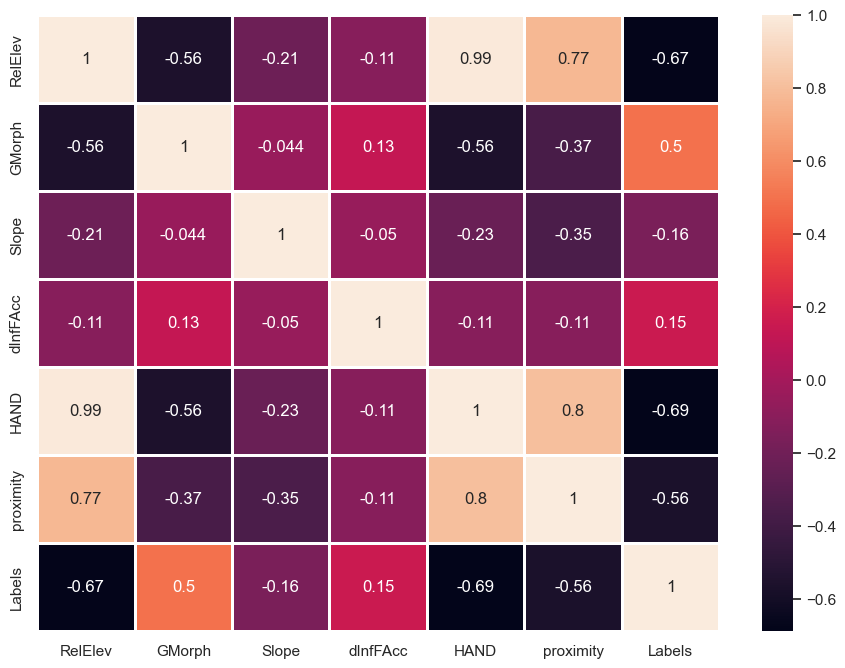

In [25]:
####. Covariance Matrix
fig, ax = plt.subplots(figsize=(11, 8))
ax.font_scale = 10
sns.set_theme(font_scale=1)
matrix = reader.corr().round(3)
print(matrix)

sns.heatmap(matrix,annot=True, linewidth=1)

In [ ]:
### Pairplot ###
sns.set_theme(font_scale=1.5)
sns.pairplot(reader, hue = 'Labels', diag_kind = 'kde', 
             plot_kws = {'alpha': 0.8, 's': 100},
             height = 4, corner=True, palette = "Set2")# vars = ['life_exp', 'log_pop', 'log_gdp_per_cap'],

# sns.pairplot(DS, hue="percentage")

In [ ]:
# listeNames = ['Elev','RelElev','GMorph','FloodOrd','Slope','d8fllowAcc','HAND','proximity','Labels', 'Aoi_Id']

plt.figure(figsize=(10, 6))
sns.scatterplot(data=reader, x='Elev', y='RelElev', hue='Labels', palette='Set2')

In [ ]:
class1_Tr = r'C:\Users\abfernan\CrossCanFloodMapping\FloodMappingProjData\HRDTMByAOI\A_DatasetsForMLP\StratifiedSampling\class5_Full.csv'
reader =  pd.read_csv(class1_Tr,index_col=None)
count = reader.shape[0]
print(count)
positives = reader[reader['Labels'] == 1].shape[0]
posPercent = positives/count

negatives = reader[reader['Labels'] == 0].shape[0]
print(count)
negPercent = negatives/count

print(positives, posPercent)
print(negatives, negPercent)


##### Euclidean distance between Datasets

In [ ]:
colsToCompare = ['RelElev','HAND','proximity',]
pathA = r'C:\Users\abfernan\CrossCanFloodMapping\FloodMappingProjData\HRDTMByAOI\A_DatasetsForMLP\RegionalModelingApplication\NF_StJohnsMultyResolution\class1_TrainingAllVsStJohns_RasterizedMode_Cleaned_Normal.csv'
pathB = r'C:\Users\abfernan\CrossCanFloodMapping\FloodMappingProjData\HRDTMByAOI\A_DatasetsForMLP\RegionalModelingApplication\NF_StJohnsMultyResolution\StJohns16m_Dataset_Class1_Cleaned_Normal.csv'

datasetA = pd.read_csv(pathA,index_col=None)
datasetA = datasetA[datasetA['proximity']<=1500]
print(datasetA.describe())
datasetB = pd.read_csv(pathB,index_col=None)
datasetB = datasetB[datasetB['proximity']<=1500][10000:10003]

gc.collect()

In [ ]:
distanceByFeature, meanDist = ms.datasetsEuclideanDistances(datasetA,datasetB,colsToCompare)
print(distanceByFeature)

del distanceByFeature, meanDist
#mean distance between the two datasets:453.64160770221173

In [ ]:
a = csim(datasetA[colsToCompare],datasetB[colsToCompare])
# print(a)
print(np.mean(a))

del a


In [ ]:
gc.collect()

# Model analyse

### Model description

In [ ]:

model = ms.loadModel(r'C:\Users\abfernan\CrossCanFloodMapping\FloodMappingProjData\HRDTMByAOI\MLP_Models\2405231700.pkl')
par,total = ms.count_parameters(model)

### Feature importance

In [ ]:
datasetPath = r'C:\Users\abfernan\CrossCanFloodMapping\FloodMappingProjData\HRDTMByAOI\A_DatasetsForMLP\RegionalModelingExplorationDatasets\IndividualsClass1ForRegModelingExpl\TrainingDatasets\TrainingDatasetCombined\AL_Lethbridge_VsAll\AL_Lethbridge_normalWRT_All.csv'
labels = 'Labels'
colsToDrop = ['x_coord','y_coord'] 
model = ms.loadModel(r'C:\Users\abfernan\CrossCanFloodMapping\FloodMappingProjData\HRDTMByAOI\MLP_Models\2405231657.pkl')

print('---------Starting feature importance ----------')

met = md.F1_Macro_Average
md.permutation_importance(datasetPath,labels,model,met,colsToDrop)


# UMAP exploration

In [ ]:
import umap

def draw_umap(data, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data)
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=data)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=data)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=data, s=100)
    plt.title(title, fontsize=18)

In [ ]:
# dataNames = ['RelElev','GMorph','FloodOrd','Slope','d8fllowAcc','HAND','proximity','Labels','Aoi_Id']

data = np.array(reader[['RelElev','GMorph','Slope','HAND','proximity']])
contains_nan = np.isnan(data).any()
print('data contains_nan? :', contains_nan)

labels = np.array(reader['Labels'])

embedding = umap.UMAP(n_neighbors = 15,
                     metric='euclidean',
                     min_dist=0.99,
                     n_components=2,
                     ).fit_transform(data,y=labels)

In [ ]:
dataset = np.empty((embedding.shape[0],4))
dataset[:,:2]= embedding
dataset[:,2]= np.array(reader['Labels'])
dataset[:,3]= np.array(reader['Aoi_Id'])
dataFrame = pd.DataFrame(dataset, columns=['x','y','Labels','Aoi_Id'])

In [ ]:

positives = dataFrame[dataFrame['Labels'] == 0]

print(positives.shape)

In [ ]:

classes = reader['Aoi_Id']
classesUnique = np.unique(classes)
print(classesUnique)

fig, ax = plt.subplots(1, figsize=(10, 8))
plt.scatter(dataFrame['x'],dataFrame['y'], s=0.1, c=dataFrame['Aoi_Id'], cmap='Spectral')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(41)-0.5)
cbar.set_ticks(np.arange(40))
# cbar.set_ticklabels(classesUnique)
plt.title('Testing UMAP in flood modeling \n n_neighbors=15, metric=euclidean, min_dist=0.99 \n Class5 \n zones = [ 1  2  3  4  5  6  7 10 13 22 23 24 25 26 28 29 30]')# n_neighbors=5, metric=euclidean, min_dist=0.2

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positives['x'], positives['y'], positives['z'], c=positives['Aoi_Id'], s=1)

In [ ]:
### Import DataSet 
readSetPath = 'datasets/datasets4MLP/'
importName = 'MLP_basin5_Test.csv'
saveDatasetPath = 'datasets/datasets4MLP_Binary/'
basinDataSet = pd.read_csv((readSetPath+importName), index_col = None)

basinDataSet = ms.makeBinary(basinDataSet,'percentage',0,1)

exportName = 'MLPBinary_basin5_Test.csv'
basinDataSet.to_csv((saveDatasetPath+exportName), index=None)

basinDataSet.describe()
basinDataSet.head()

In [ ]:
colNames = ['percentage','DLSOL5R200', 'DLSOL4R150', 'DLSOL5R150']
for col in colNames: 
    basinDataSet[col].fillna(0,inplace=True)

In [ ]:
## Transform a column datatype
repalcer  = basinDataSet['percentage'].to_numpy().astype('int32')
print(repalcer[0:10],repalcer.dtype)
basinDataSet.loc[:,'percentage'] = repalcer

In [ ]:
### Make binary Dataset ###
# keep class_0 and replace with 1 all other classes. 
basinDataSet = ms.makeBinary(basinDataSet,'percentage',0,1)


In [ ]:
basinDataSet.describe()

In [ ]:
basinDataSet.head()

In [ ]:
basinDataSet.isna().any()

In [ ]:
exportName = 'MLPBinary_basin3_Training.csv'
basinDataSet.to_csv((saveDatasetPath+exportName), index=None)

In [ ]:
### Replacing QGIS NoData value(-9999) with 0 
repalcer  = basinDataSet['FAProx_01'].to_numpy()
basinDataSet['FAProx_01'] = [0 if repalcer[j] == -9999 else repalcer[j] for j in range(len(repalcer))]                                                                                                                         
                                                                                                                          

In [ ]:
basinDataSet.dropna(subset=['slope'],inplace=True)

In [ ]:
basinDataSet.drop(['fid'], axis =1, inplace=True)

In [ ]:
basinDataSet.isna().sum()

In [ ]:
#### NOrmalize Flow Accumulation
basinDataSet['FAcc'] = (basinDataSet['FAcc']- basinDataSet['FAcc'].min())/(basinDataSet['FAcc'].max()-basinDataSet['FAcc'].min())


In [ ]:
ds = DS.head(5)
s = {}
s['Datas'] = ds
print(s)

## Proportional Spliting 

In [ ]:
## Stratified Split
from sklearn.model_selection import StratifiedShuffleSplit

X,Y = ms.importDataSet('datasets/basin1_FirstFeatureSet_Clean.csv', 'percentage')
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=50)
for train_index, test_index in sss.split(X, Y):
    print("TRAIN:", train_index.size, "TEST:", test_index.size)
    X_train = X.iloc[train_index]
    y_train = Y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = Y.iloc[test_index]

In [ ]:
## Describing training set
print(len(X_train['elevation']), len(y_train) )
trainCount = Counter(y_train)
print(trainCount)

In [ ]:
#####    Creating training set     #####
X_train.loc[:,'percentage'] = y_train
X_train.head()


In [ ]:
## Removing coordinates from training set
X_train.drop(['x_coord','y_coord'], axis =1, inplace=True)
X_train.head()

In [ ]:
X_train.to_csv('datasets/basin1_FirstFeatureSet_Clean_Training.csv', index=None)

In [ ]:
#####. Creating Test set
print(X_test.head())
X_test.loc[:,'percentage'] = y_test
print(X_test.head())
print(X_test.info())
testCount = Counter(X_test['percentage'])
print(f"testCount:  {testCount}")


In [ ]:
X_test.to_csv('datasets/basin1_FirstFeatureSet_Clean_Test.csv', index=None)

In [ ]:
## This proportions are the reason why a sample_weight of 0.01 for the majority class give best results for regression
totalTrain = sum([trainCount[0], trainCount[1], trainCount[5]]) 
totalValidation = sum([testCount[0], testCount[1], testCount[5]])
print(f"total Train samples: {totalTrain},  total Validation samples: {totalValidation}")
print("Summary of traning and test dataset class balance")
print(f"Training Set:", '\n', "Class 0: %.3f" %(trainCount[0]/totalTrain), " Class 1: %.4f" %(trainCount[1]/totalTrain), "Class 5: %.4f"%(trainCount[5]/totalTrain))
print("Testing Set:", '\n', "Class 0: %.3f" %(testCount[0]/totalValidation)," Class 1: %.4f" %(testCount[1]/totalValidation),  "Class 5: %.4f"%(testCount[5]/totalValidation))



In [ ]:
model = ms.loadModel('./outputs/2022-08-05/00-35-58/2208050035.pkl')
dataSetToSave = ms.makePredictionToImportAsSHP(csvName, model, X, Y, 'percentage')
print(dataSetToSave.head())

## Combining dataSets to build AllVsOne_training and OneVsAll_test

In [ ]:
# Concat datasets
sourceFileForDatasets = 'datasets/'
allDataSetsNames = ['basin1Light_Clean.csv', 'basin2_CleanDataSet.csv', 'basin3_CleanDataSet_copy.csv','basin4_CleanDataSet.csv','basin5_CleanDataSet.csv']
# OneVsAllDataSetName = 'basin1Light_Clean.csv'

for datasetForTest in allDataSetsNames:
    filename, file_extension = os.path.splitext(datasetForTest)
    newListOfNames = [s for s in allDataSetsNames if s != datasetForTest]
    allDataSetsFileName = 'allVs_'+ filename +'_Training'
    DFToConcatAll = pd.DataFrame()
#     DFToConcatAll = pd.read_csv((sourceFileForDatasets+datasetForTest), index_col = None)
#     print(DFToConcatAll.head())
    for datasets in newListOfNames:
        DFToConcatAll = pd.concat([DFToConcatAll, pd.read_csv((sourceFileForDatasets+datasets), index_col = None)])
    nameToSafe = sourceFileForDatasets+allDataSetsFileName+file_extension
    DFToConcatAll.drop(['x_coord','y_coord'], axis =1, inplace=True)
    DFToConcatAll.to_csv(nameToSafe, index=None)    
    



## Preparing datasets for MLP

In [ ]:
destiationPath = 'datasets/RFdatasets'
listFile = os.listdir(destiationPath)
print(listFile)

In [ ]:
testList = ['basin1Light_Clean_Test.csv','basin2_Test.csv','basin3_Test.csv','basin4_Test.csv','basin5_Test.csv']
traininList = ['basin1Light_Clean_Training.csv','basin2_Training.csv','basin3_Training.csv','basin4_Training.csv','basin5_Training.csv']

In [ ]:
## Cleaning datasets: Removing not usefull variables from All_VS_ONE 
readPath = 'datasets/RFdatasets/'
destiationPath = 'datasets/dataset4MLP/'
datasetNamelist = ['basin1Light_Clean_Test.csv','basin2_Test.csv','basin3_Test.csv','basin4_Test.csv','basin5_Test.csv',
                  'basin1Light_Clean_Training.csv','basin2_Training.csv','basin3_Training.csv','basin4_Training.csv',
                   'basin5_Training.csv']
featuresToDelete = ['TPI','TWI']
for i in datasetNamelist:
    path = readPath + i 
    basinDataSet = pd.read_csv(path, index_col = None)
    basinDataSet.drop(featuresToDelete, axis=1, inplace=True)
    savePath = destiationPath + 'MLP_'+ i
    basinDataSet.to_csv(savePath, index=None)


In [ ]:
###. Build dataset subset for MLP test (Only first 150K samples)
readPath = 'datasets/dataset4MLP/'
datasetNamelist = ['MLP_allVs_basin1Light_Clean_Training.csv','MLP_basin1Light_Clean_VsAll_Test.csv']
for i in datasetNamelist:
    path = readPath + i 
    basinDataSet = pd.read_csv(path, index_col = None)
    Y = np.array(basinDataSet['percentage'])
    count,_ = md.listClassCountPercent(Y)
    basinDataSet.drop(basinDataSet.loc[150000:count].index,axis=0,inplace=True)
    savePath = readPath + 'reduced_'+i
    basinDataSet.to_csv(savePath, index=None)

In [ ]:
### Exploring datasets
dataset = ['reduced_MLP_allVs_basin1Light_Clean_Training.csv','reduced_MLP_basin1Light_Clean_VsAll_Test.csv']
for i in dataset:
    path = readPath + i 
    print(path)
    basinDataSet = pd.read_csv(path, index_col = None)
    print(basinDataSet.head())
    Y = np.array(basinDataSet['percentage'])
    print(md.listClassCountPercent(Y))

In [ ]:
####.  Training TEST
readPath = 'datasets/dataset4MLP/'
trainingPath = readPath + 'MLP_allVs_basin1Light_Clean_Training.csv'
params = {'random_state':50, 'hidden_layer_sizes': 2,
                'early_stopping':True,'max_iter':200,'verbose':False,
                'tol':0.00010,'validation_fraction':0.1,'warm_start':False}
mlpc = md.implementingMLPCalssifier(trainingPath,'percentage',params)
mlpc.fitMLPClassifier()
mlpc.plotLossBehaviour()

mlpClassifier = mlpc.getMLPClassifier()

# #Validating un unseen datase
# validation = readPath + 'MLP_basin1Light_Clean_VsAll_Test.csv'
# x_val,y_val = ms.importDataSet(validation, 'percentage')
# prediction = ms.makePredictionToImportAsSHP(mlpClassifier, x_val, y_val, 'percentage')

# ## Compute metrics
# X = x_val.copy()
# X.drop(['x_coord','y_coord'], axis=1, inplace=True)
# metrics = md.computeClassificationMetrics(mlpClassifier,X,y_val)

In [ ]:
print(mlpc.get_logsDic())
mlpc.logMLPClassifier({'test':34})
print(mlpc.get_logsDic())

In [ ]:
prediction.to_csv(('outputs/'+ 'MLP_basin1Light_firstResult_HL280.csv'),index=None)

In [ ]:
### Implement bets hiddenLayerSize exploration
readPath = 'datasets/dataset4MLP/'
trainingPath = readPath + 'MLP_allVs_basin1Light_Clean_Training.csv'
validation = readPath + 'MLP_basin1Light_Clean_VsAll_Test.csv'
# dataset = pd.read_csv(trainingPath, index_col = None)
params = {'random_state':50, 'hidden_layer_sizes': 2,
                'early_stopping':False,'max_iter':2,'verbose':True,
                'tol':0.00010,'validation_fraction':0.1,'warm_start':False}
mlpc = md.implementingMLPCalssifier(trainingPath,'percentage',params)

x_val,Y_val = ms.importDataSet(validation, 'percentage')
X = x_val.copy()
X.drop(['x_coord','y_coord'], axis=1, inplace=True)
firstInterval = np.arange(100,1009,100)
mlpc.explore4BestHLSize(X,Y_val,firstInterval,'5',3)

## Controled sampling

In [ ]:
DS = pd.read_csv('datasets/basin2 _Training.csv', index_col = None)
print(DS.head())


In [ ]:
print(DS.columns)

In [ ]:
plt.boxplot(DS['FAProx_01']) # , , DS['elevation'], DS['disToRiv']]

In [ ]:
## Resampling appliying class selection by rule:

# RULE1: Select point at a distance to river less than 300m. 

# # newDS = pseudoClassCreation(DS, "distanceToRiver", 300, 2)
def pseudoClassCreation(dataset, conditionVariable, threshold, pseudoClass, targetClassName):
    '''
    Replace <targetClass> by  <pseudoClass> where <conditionVariable >= threshold>. 
    Return:
      dataset with new classes group. 
    '''
    datsetReclassified = dataset.copy()
    actualTarget = (np.array(dataset[targetClassName])).ravel()
    conditionVar = (np.array(dataset[conditionVariable])).ravel()
    datsetReclassified[targetClassName] = [ pseudoClass if conditionVar[j] >= threshold 
                                           else actualTarget[j]
                                           for j in range(len(actualTarget))]
    print(Counter(datsetReclassified[targetClassName]))
    return  datsetReclassified

def revertPseudoClassCreation(dataset, originalClass, pseudoClass, targetClassName):
    '''
    Restablich  <targetClass> with <originalClass> where <targetClassName == pseudoClass>. 
    Return:
      dataset with original classes group. 
    '''
    datsetReclassified = dataset.copy()
    actualTarget = (np.array(dataset[targetClassName])).ravel()
    datsetReclassified[targetClassName] = [ originalClass if actualTarget[j] == pseudoClass
                                           else actualTarget[j]
                                           for j in range(len(actualTarget))]
    print(Counter(datsetReclassified[targetClassName]))
    return  datsetReclassified


print(Counter(X_train['percentage']))
newDS = pseudoClassCreation(X_train, 'disToRiv', 200, 2, 'percentage')
y = newDS['percentage']
newDS.drop(['percentage'], axis=1, inplace = True)
x_res,y_res = ms.randomUndersampling(newDS, y, )
x_res['percentage'] = y_res
# newDatase = revertPseudoClassCreation(x_res, 0, 2, 'percentage')


In [ ]:
x_res.to_csv('basin1ControlClass0Sampling4Class_ToSHP.csv',index = None)

# Data description and visualization

In [ ]:
#### import dataset to describe
DS= pd.read_csv('datasets/RFDatasets/basin5_CleanDataSet.csv', index_col=None)
DS.drop(['x_coord','y_coord'], axis=1, inplace=True)
DS.head()

In [ ]:
####. Covariance Matrix
fig, ax = plt.subplots(figsize=(15, 10))
ax.font_scale = 9
# sns.set(font_scale=1.5)
matrix = DS.corr().round(2)
sns.heatmap(matrix, annot=True, linewidth=1)


In [ ]:
DS.drop(['x_coord','y_coord'], axis = 1, inplace=True)
DS.head()

In [ ]:
def plotVectorsPDFComparison(vectorList:list,nameList:list=[],title:str='PDF', histBins:int=1, addmax= False):
    '''
    # this create the kernel, given an array, it will estimate the probability over that values
    kde = gaussian_kde( data )
    # these are the values over which your kernel will be evaluated
    dist_space = linspace( min(data), max(data), 100 )
    # plot the results
    plt.plot( dist_space, kde(dist_space))
    @vectorList:list,
    @title:str='RasterPDF' 
    @bins:int = 100 
    ''' 
    global_Min = 0
    global_Max = -np.inf
    fullDataSet = np.array([], dtype=np.float32)
    i= 0

    ### Prepare plot
    fig, ax = plt.subplots(1,sharey=True, sharex=True, tight_layout=True,facecolor='none')
    plt.grid(True, color='black', linestyle='--', linewidth=0.1)
    # plt.legend(loc=0, bbox_to_anchor=(1.1,1.5))
    colors = plt.cm.turbo(np.linspace(0, 1, 10*len(vectorList)))# 
    '''
    turbo; jet; nipy_spectral;gist_ncar;gist_rainbow;rainbow, brg
    '''
    colorIdx = 4
    for item in vectorList:
        dataMin =  np.min(item)
        relativeElevation = np.subtract(item,dataMin)
        fullDataSet = np.concatenate((fullDataSet,relativeElevation))
        dataMin =  np.min(relativeElevation)
        dataMax = np.max(relativeElevation)
        global_Min = np.minimum(global_Min,dataMin)
        global_Max = np.maximum(global_Max,dataMax)

        ## If <bins> is a list, add the maximum value to <bins>.  
        if (addmax and isinstance(bins,list)):
            bins.append(global_Max).astype(int)
        counts, bins = np.histogram(item, bins=histBins)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        ax.plot(bin_centers, counts,color=colors[colorIdx],linewidth=0.8)
        # nameList.append(f'Vector {i}')
        i+=1
        colorIdx+=4
        
    # ## UNcoment to Plot global PDF
    # counts, bins = np.histogram(fullDataSet, bins= 400)
    # bin_centers = 0.5 * (bins[:-1] + bins[1:])
    # ax.plot(bin_centers, counts,color='red',linewidth=0.9, label='global')
    # nameList.append('global')
    
    ## Complet plot space
    ax.legend(nameList, prop={'size': 11},loc ='upper right')
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Normalized values')

In [ ]:
## Histograms
## Import 
colsToDescribe = ['RelElev', 'GMorph','Slope','d8fllowAcc','HAND','proximity']

colsToCompare = ['RelElev','HAND','proximity']

pathTrainingDataset = r'C:\Users\abfernan\CrossCanFloodMapping\FloodMappingProjData\HRDTMByAOI\A_DatasetsForMLP\RegionalModelingExplorationDatasets\IndividualsClass1ForRegModelingExpl\TrainingDatasets\TrainingDatasetCombined\Al_Lethbridge_Vs_2_5_13_19_30_31\AL_Lethbridge_Top5TrNorm.csv'

pathValidationDataset = r'C:\Users\abfernan\CrossCanFloodMapping\FloodMappingProjData\HRDTMByAOI\A_DatasetsForMLP\RegionalModelingExplorationDatasets\IndividualsClass1ForRegModelingExpl\TrainingDatasets\TrainingDatasetCombined\Al_Lethbridge_Vs_2_5_13_19_30_31\AL_Lethbridge_RMAOI_normalWRT_Top5Tr.csv'

datasetA = pd.read_csv(pathTrainingDataset,index_col=None)
print(datasetA.describe())
datasetB = pd.read_csv(pathValidationDataset,index_col=None)
print(datasetB.describe())

labelsA = datasetA['Labels'].values
unique, counts = np.unique(labelsA, return_counts=True)
print("Label balance on Training set: ", "\n",unique,"\n",counts)

labelsB = datasetB['Labels'].values
unique, counts = np.unique(labelsB, return_counts=True)
print("Label balance on validation set: ", "\n",unique,"\n",counts)


### Satandardize:
# datasetB = ms.normalizeDatasetByColNameList(pathTrainingDataset,colNamesList=colsToCompare)
# datasetA = ms.normalizeDatasetByColNameList(pathTrainingDataset,pathValidationDataset,colNamesList=colsToCompare)


### Save Summary
# datasetA[colsToDescribel].describe().round(2).to_csv(r'C:\Users\abfernan\CrossCanFloodMapping\GitLabRepos\FloodProbabRNCanAbd\local\NF_PortugalCove_Sumary.csv', sep=';')
# datasetB[colsToDescribel].describe().round(2).to_csv(r'C:\Users\abfernan\CrossCanFloodMapping\GitLabRepos\FloodProbabRNCanAbd\local\NF_Shearstown_Sumary.csv', sep=';')
# print(datasetA.describe(),'\n', datasetB.describe())


### Plot Histogramas of all values. 
namelist = ['All available basins','AL_Lethbridge']
bins = 80

colName = 'RelElev'
plotVectorsPDFComparison([datasetA[colName].values,datasetB[colName].values],namelist,title=colName, histBins=bins)
colName = 'HAND'
plotVectorsPDFComparison([datasetA[colName].values,datasetB[colName].values],namelist,title=colName, histBins=bins)
colName = 'proximity'
plotVectorsPDFComparison([datasetA[colName].values,datasetB[colName].values],namelist,title=colName, histBins=bins)
# # _,_ = ms.datasetsEuclideanDistances(datasetA,datasetB,colsToCompare)

In [ ]:
# Crear datos de vectores
vectorB = datasetB[colsToCompare].values
vectorA = datasetA[colsToCompare].values

# Crear la figura 3D
ax = plt.axes(projection='3d')
# ax = fig.add_subplot(111, projection='3d')

# # Dibujar cada vector
# for vector in vectorB:
#     ax.quiver(0, 0, 0, vector[0], vector[1], vector[2])
xb= vectorB
yb= vectorB
zb= vectorB
xa= vectorA
ya= vectorA
za= vectorA

# Establecer límites de la gráfica
ax.set_xlim([-0.1, 25])
ax.set_ylim([-0.1, 25])
ax.set_zlim([-0.1, 25])

ax.scatter(xb,yb,zb, marker='o', alpha=0.1)
ax.scatter(xa,ya,za, marker='x', alpha=0.1)


# Mostrar la gráfica
plt.show()

In [ ]:
### 3D Visualization

from stl import mesh


def vectorTo_STL(vector_3d, stlPath):
    dims = vector_3d.shape
    print(vector_3d.shape)
    print(vector_3d[0])
    # Crea el objeto mesh
    your_mesh = mesh.Mesh(np.zeros((dims[0],dims[1]), dtype=mesh.Mesh.dtype))

    for i, f in enumerate(vector_3d):
        for j in range(3):
            your_mesh.vectors[i][j] = vector_3d[i][j]

    # Escribe el archivo STL
    your_mesh.save(stlPath)

In [ ]:
vectorA = datasetA[colsToCompare].values
path = 'vectorA.stl'
vectorTo_STL(vectorA,path)

In [ ]:
vectorB = datasetB[colsToCompare].values
path = 'vectorB.stl'
vectorTo_STL(vectorB,path)

In [ ]:
import faiss  

# make faiss available
vectorA = datasetA[colsToCompare].values
index = faiss.IndexPQ()  # build the index
print(index.is_trained)
index.add(vectorA)                  # add vectors to the index
print(index.ntotal)
vectorB = datasetB[colsToCompare].values
index.add(vectorB[:1])                  # add vectors to the index
print(index.ntotal)

In [ ]:
%%time
k = 4                          # we want to see 4 nearest neighbors
D, I = index.search(vectorA,10) # sanity check
print(I.shape)
# print(D)

In [ ]:
### FAcc vs Labels
targets = DS['percentage']
colList = ['FAProx_01','FAProx_025','FAcc']
fig, axs = plt.subplots(1,3, figsize=(15,5), sharey=True)
fig.text(-0.02, 0.5, 'Flood probability (%)', va='center', rotation='vertical')
fig.text(0.5, 1, 'Density Lines vs labels distribution', ha ='center')
j=0
for i in colList:
    axs[j].scatter(DS[i],targets)
    # axs[j].set_title(i)
    axs[j].set(xlabel= i)
    j+=1

plt.rcParams['font.size'] = '20'
fig.tight_layout()


In [ ]:

## Plot all features vs labels
# 'disToRiv', 'TWI', 'TPI', 'slope', 'elevation',

targets = DS['percentage']
# targets = np.where(targets == 5,2,targets)

E = DS['elevation'] 
slope = DS['slope']
FAcc = DS['FAcc']
TWI = DS['TWI']
TPI = DS['TPI']
DLSOL4R150 = DS['LDSOL4R150']
DLSOL5R150 = DS['LDSOL5R150']
DLSOL5R200 = DS['LDSOL5R200']
FAProx_01 = DS['FAProx_01']
FAProx_025 = DS['FAProx_025']
visibility = DS['visibility']

fig, axs = plt.subplots(4,3, figsize=(13, 8), sharey=True)
fig.supylabel('Labels')
plt.rcParams['font.size'] = '15'
plt.yticks([0,1,5])

'''
E = DS['elevation'] 
slope = DS['slope']
FAcc = DS['FAcc']
TWI = DS['TWI']
'''
axs[0, 0].scatter(E,targets)
axs[0, 0].set_title("Elevation")
axs[1, 0].scatter(slope,targets)
axs[1, 0].set_title("Slope")
axs[2, 0].scatter(FAcc,targets)
axs[2, 0].set_title("Flow accumulation")
axs[3, 0].scatter(TWI,targets)
axs[3, 0].set_title("TWI")

'''
TPI = DS['TPI']
DLSOL4R150 = DS['DLSOL4R150']
DLSOL5R150 = DS['DLSOL5R150']
DLSOL5R200 = DS['DLSOL5R200']
'''
axs[0, 1].scatter(TPI,targets)
axs[0, 1].set_title('TPI')
axs[1, 1].scatter(DLSOL4R150,targets)
axs[1, 1].set_title("DLSOL4R150")
axs[2, 1].scatter(DLSOL5R150,targets)
axs[2, 1].set_title("DLSOL5R150")
axs[3, 1].scatter(DLSOL5R200,targets)
axs[3, 1].set_title("DLSOL5R200")

'''
FAProx_01 = DS['FAProx_01']
FAProx_025 = DS['FAProx_025']
visibility = DS['visibility']
'''
axs[0, 2].scatter(FAProx_01,targets)
axs[0, 2].set_title('FAProx_01')
axs[1, 2].scatter(FAProx_025,targets)
axs[1, 2].set_title("FAProx_025")
axs[2, 2].scatter(visibility,targets)
axs[2, 2].set_title("Visibility")

fig.tight_layout()


In [ ]:
print(DS.head())
#  Return a dataset with the rows corresponding to the index where condition in DS.columName is valid. 
dsArray = DS[DS.percentage != 0] 
print(dsArray.head()) 

In [ ]:
### Pairplot ###

sns.set_theme(font_scale=1.5)
sns.pairplot(DS, hue = 'percentage', diag_kind = 'kde', 
             plot_kws = {'alpha': 0.8, 's': 100},
             height = 4, corner=True, palette = "Set2")# vars = ['life_exp', 'log_pop', 'log_gdp_per_cap'],

# sns.pairplot(DS, hue="percentage")

In [ ]:
### Pairplot ###

sns.set_theme(font_scale=1.5)
sns.pairplot(DS, hue = 'percentage', diag_kind = 'kde', 
             plot_kws = {'alpha': 0.8, 's': 100},
             height = 4, corner=True, palette = "Set2")# vars = ['life_exp', 'log_pop', 'log_gdp_per_cap'],

# sns.pairplot(DS, hue="percentage")

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(criterion='entropy', random_state = 50)
x_train,y_train = ms.importDataSet('basin1Train.csv', 'percentage')
classifier = OneVsRestClassifier(estimator).fit(x_train,y_train)


In [ ]:
classifier = ms.loadModel('outputs/2022-11-01/10-51-40/2211011051.pkl')
x_test,y_test = ms.importDataSet('datasets/datasets4MLP_Binary/MLPBinary_basin1_Test.csv', 'percentage')

x_test = ms.removeCoordinatesFromDataSet(x_test)

# y_prob = classifier.predict_proba(x_test)
#print(np.unique(y_prob))

md.plot_ROC_AUC(classifier, x_test, y_test)

In [ ]:
#### ROC_AUC binary for multiples results in the same figure 

fig, axs = plt.subplots(1,figsize=(13,4), sharey=True)
plt.rcParams.update({'font.size': 14})
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=16)
plt.figure(0).clf()
axs.set_title('MLP binary in Basin 5')

classifierList = ['outputs/2022-11-02/09-30-03/2211020930.pkl', 'outputs/2022-10-31/09-57-31/2210310957.pkl']
testSetList = ['datasets/datasets4MLP_Binary/MLPBinary_basin5_Test.csv', 'datasets/datasets4MLP_Binary/MLPBinary_basin5_VsAll_Test.csv']
nameList = ['Intra-Basins','one-vs-rest']
for i in range(len(classifierList)):
    classifier = ms.loadModel(classifierList[i])
    x_test,y_test = ms.importDataSet(testSetList[i], 'percentage')
    x_test = ms.removeCoordinatesFromDataSet(x_test)
    y_prob = classifier.predict_proba(x_test)  
    y_hat = classifier.predict(x_test)
    fpr,tpr,thresholds = metrics.roc_curve(y_test, y_prob[:,1], drop_intermediate=False) 
    print(thresholds)
    roc_auc = roc_auc_score(y_test, y_hat, average = "macro")
    axs.plot(fpr,tpr,label = str(nameList[i]) + " AUC : " + format(roc_auc,".4f")) 
    axs.legend()

### Inference 

In [ ]:
modelsFolder = r'C:\Users\abfernan\CrossCanFloodMapping\FloodMappingProjData\HRDTMByAOI\MLP_Models'
modelName = '2401222228'
model = ms.loadModel(os.path.join(modelsFolder,modelName+'.pkl'))
datasetPath = r'C:\Users\abfernan\CrossCanFloodMapping\FloodMappingProjData\HRDTMByAOI\A_DatasetsForMLP\RegionalModelingExplorationDatasets\RasterMode\ValidationDataset_RastMode_Normalized_class1.csv'
colsToDrop = ['x_coord','y_coord','Labels']
y_hat = md.inferenceMLP(datasetPath,model=model,colsToDrop=colsToDrop)
# print(metrics)

In [ ]:
## Prepare output dataset for QGIS
outDataFrame = pd.DataFrame()
inDataFrame = pd.read_csv(datasetPath, index_col=None)
# colsToDrop.append('Labels')
outDataFrame = inDataFrame[colsToDrop]

outDataFrame['y_hat'] = y_hat

# print(outDataFrame.describe())
RMA_outputs =r'C:\Users\abfernan\CrossCanFloodMapping\FloodMappingProjData\HRDTMByAOI\A_DatasetsForMLP\RegionalModelingApplication\RMA_outputs'
_,name,ext = ms.get_parenPath_name_ext(datasetPath)
outPrediction = os.path.join(RMA_outputs,name+'_RMA_'+modelName+ext)

#r'C:\Users\abfernan\CrossCanFloodMapping\FloodMappingProjData\HRDTMByAOI\A_DatasetsForMLP\RegionalModelingApplication\RMA_outputs\QC_Plessisville_FullBasin_RMA_Scaled_Class_5_RMA_2401161113.csv'
print(outDataFrame.describe())
outDataFrame.to_csv(outPrediction, index=False)

In [ ]:
ms.buildShapefilePointFromCsvDataframe(outPrediction)